# 3. Predicting Dating App Subreddit with Natural Language Processing

# Standard Imports

In [1]:
# standard imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import re

# bs4, nltk, and sklearn imports
from bs4 import BeautifulSoup             
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

pd.set_option("display.max_rows", None, "display.max_columns", None)

### Reading in CSV File

In [2]:
both_dfs = pd.read_csv('dataframes/both_dfs.csv')
both_dfs = pd.DataFrame(data = both_dfs)
both_dfs.head()

,title,selftext,title_self_text,subreddit
0,And another one bites the dust,NaN,And another one bites the dust,0
1,The microwavegirl,NaN,The microwavegirl,0
2,Well it’s sort of a tactic,NaN,Well it’s sort of a tactic,0
3,I like to keep up with current events,NaN,I like to keep up with current events,0
4,How do super likes work?,So I super liked this girl and we matched. Wha...,How do super likes work? So I super liked this...,0


# Train Test Split

We will be performing a train-test-split on the data so we can train our data to predict subreddit with a prior training dataset first. Then we can model the test set to check the effectiveness of our training model.

In [3]:
X = both_dfs['title_self_text']
y = both_dfs['subreddit']

y.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# Tokenizing and Preprocessing Data

The data needs to be changed into a form that we can work with more easily. Every string needs to be broken into single words with Tokenizer and Beautiful Soup, every word should be lowercase, every punctuation mark should be removed, and stopwords should be removed to make sure the models don't immediately flag one of the subreddits (it would be too easy).

In [5]:
def cleaning_post(single_post): # Developed from 5.3 lesson with Patrick Wales Dinan
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # 1. Remove HTML.
    post_text = BeautifulSoup(single_post).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    new_stops = ['tinder','bio','profile','profiles','like','removed','remove',
                 'bio','bios','account','accounts','looking','match','matches',
                'relationship','relationships','advice', 'swipe', 'right', 'left', 'like']
    stops.update(new_stops)
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [6]:
cleaning_post(both_dfs['title_self_text'][1])

'microwavegirl'

In [7]:
# Now, we need to go through EVERY post and clean them like this

In [8]:
# Initialize an empty list to hold the clean posts.
clean_train_posts = []
clean_test_posts = []

# For every post in our training set...
for train_post in X_train:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_train_posts.append(cleaning_post(train_post))

# For every review in our testing set...
for test_post in X_test:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_test_posts.append(cleaning_post(test_post))

# KNN - Random Forests

We will start instantiating and fitting models on our dataset using pipeline and gridsearch to optimize the models to a satisfactory level (100% isn't necessarily needed in this low stakes scenario). We will use the KNN and Random Forest models for this section. We will also perform evaluative statistical metrics on the predictions we make like specificity and sensitivity.

In [9]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec' , CountVectorizer()),
    ('knn' , KNeighborsClassifier(n_neighbors=5, weights='uniform'))])
    
pipe_2 = Pipeline([
    ('cvec' , CountVectorizer()),
    ('RFC' , RandomForestClassifier())])

In [10]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 200
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_params = {
    'cvec__max_features' : [200],
    'cvec__min_df' : [5], #df is document frequency
    'cvec__max_df' : [.85],
    'cvec__ngram_range' : [(1,1) , (1,2)]
}

In [11]:
# Instantiate GridSearchCV.
gs_KNN = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.
# Instantiate GridSearchCV.
gs_RFC = GridSearchCV(pipe_2, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

## KNN

In [12]:
gs_KNN.fit(clean_train_posts,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [13]:
# What's the best score?
print(gs_KNN.best_score_)

0.9649253731343282


In [14]:
# Score model on KNN set.
print(gs_KNN.score(clean_train_posts, y_train))
print(gs_KNN.score(clean_test_posts, y_test))

0.9597014925373134
0.9606060606060606


In [15]:
gs_KNN.best_estimator_

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.85,
                                 max_features=200, min_df=5, ngram_range=(1, 1),
                                 preprocessor=None, stop_words=None,
                                 strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

### KNN Predictions

We will perform evaluative statistical metrics on the predictions we make like specificity and sensitivity.

In [16]:
# Get predictions
preds = gs_KNN.predict(clean_test_posts)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

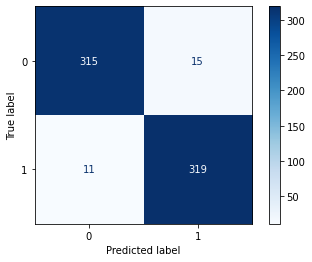

In [17]:
# View confusion matrix
plot_confusion_matrix(gs_KNN, clean_test_posts, y_test, cmap='Blues', values_format='d');

In [18]:
# What is the test specificity of our model?

spec = (tn) / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.9545


In [19]:
# What is the test sensitivity of our model?

sens = (tp) / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.9667


## Random Forest Classifier

In [20]:
gs_RFC.fit(clean_train_posts,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [21]:
# What's the best score?
print(gs_RFC.best_score_)

0.967910447761194


In [22]:
print(gs_RFC.score(clean_train_posts, y_train))
print(gs_RFC.score(clean_test_posts, y_test))

0.9746268656716418
0.9757575757575757


In [23]:
gs_RFC.best_estimator_

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.85,
                                 max_features=200, min_df=5, ngram_range=(1, 1),
                                 preprocessor=None, stop_words=None,
                                 strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                

### Random Forest Predictions

We will perform evaluative statistical metrics on the predictions we make like specificity and sensitivity.

In [24]:
# Get predictions
preds = gs_RFC.predict(clean_test_posts)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

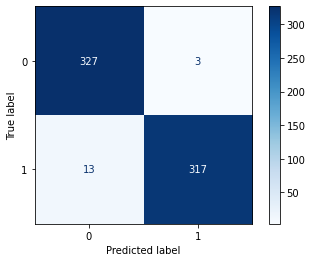

In [25]:
# View confusion matrix
plot_confusion_matrix(gs_RFC, clean_test_posts, y_test, cmap='Blues', values_format='d');

In [26]:
# What is the test specificity of our model?

spec = (tn) / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.9909


In [27]:
# What is the test sensitivity of our model?

sens = (tp) / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.9606


# Project Conclusions

|                                  | Naive-Bayes | Logistic Regression | KNN   | Random Forest |
|----------------------------------|-------------|---------------------|-------|---------------|
| Train Score                      | 87.8%       | 97.4%               | 95.9% | 97.5%         |
| Test Score                       | 88.3%       | 97.6%               | 96.1% | 97.6%         |
| Specificity (True Negative Rate) | 94.2%       | 100%                | 95.4% | 99.1%         |
| Sensitivity (True Positive Rate) | 84.2%       | 95.1%               | 96.7% | 96.1%         |

By investigating each subreddit with gender in mind, we as Tinder creators can adjust our platform to appeal even more to each gender's most statistically frequent thoughts specifically. As the second most common word in the male-dominated subreddit "Tinder" is "removed," we can have Tinder include guidelines for good chatting behavior to prevent males from being blocked. In turn, as a very common word in the female-dominated subreddit "Tinder Stories" is "date," we can include a bio question on our app detailing "Cool First, Second, and Third Date Ideas?" This will allow both genders to be clear about what kind of dating environment is personally ideal for them, raising revenue and helping people find love even more.

Despite the extreme similarities of the subreddits for Tinder and Tinder Stories, classification modeling is a form of supervised machine learning powerful enough to differentiate between these posts with a high degree of accuracy. Due to its analytical interpretability of which words are most popular, classification modeling for natural language processing will let us guide our company into the future with even more stable business decisions based on fact.